In [15]:
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms as T
import cv2
from skimage.color import lab2rgb, rgb2lab
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

# Prepare model class

In [5]:
class UnetBlock(nn.Module):
    def __init__(
        self, nf, ni, submodule=None, input_c=None, dropout=False,
        innermost=False, outermost=False
    ):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
            
        downconv = nn.Conv2d(
            input_c, ni, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(
                ni * 2, nf, kernel_size=4,
                stride=2, padding=1
            )
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(
                ni, nf, kernel_size=4,
                stride=2, padding=1, bias=False
            )
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(
                ni * 2, nf, kernel_size=4,
                stride=2, padding=1, bias=False
            )
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
            
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)
        

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(
            num_filters * 8, num_filters * 8, innermost=True
        )
        
        for _ in range(n_down - 5):
            unet_block = UnetBlock(
                num_filters * 8, num_filters * 8,
                submodule=unet_block, dropout=True
            )
            
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(
                out_filters // 2, out_filters, submodule=unet_block
            )
            out_filters //=2
            
        
        self.model = UnetBlock(
            output_c, out_filters, input_c=input_c,
            submodule=unet_block, outermost=True
        )
        
    def forward(self, x):
        return self.model(x)

In [9]:
unet = Unet()
unet.load_state_dict(torch.load('model/generator_weights.pth'))
unet.to('cuda')

summary(unet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,024
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

# Load data and inference

In [36]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'L':
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
    plt.show()

In [11]:
os.chdir('../')

In [43]:
test_images = glob.glob('data/images/Train/*.jpg')

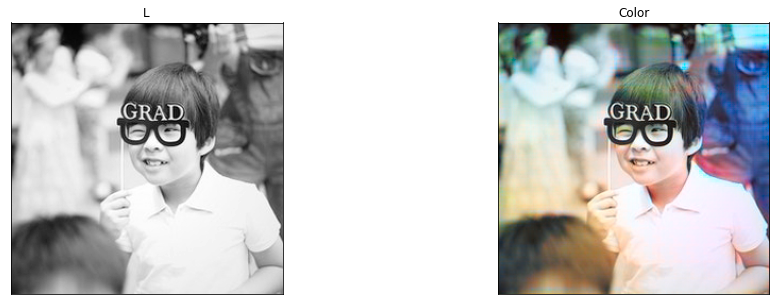

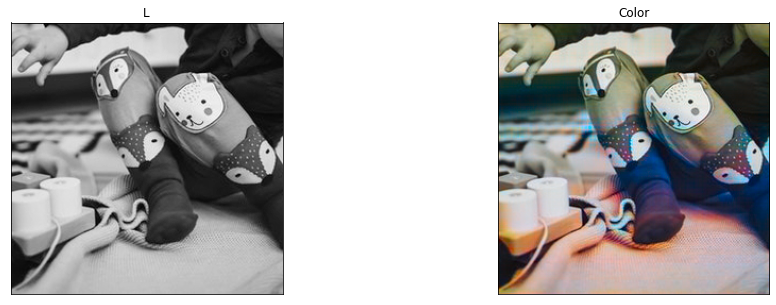

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 295 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


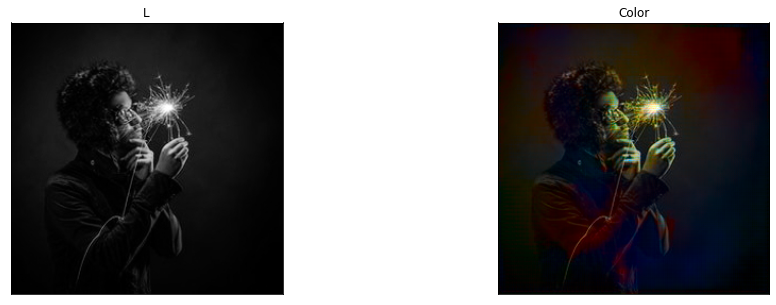

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2658 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


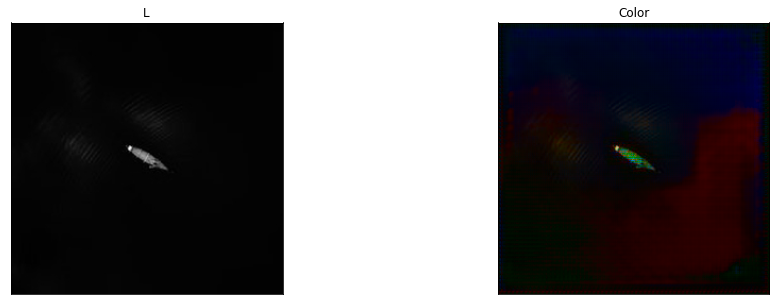

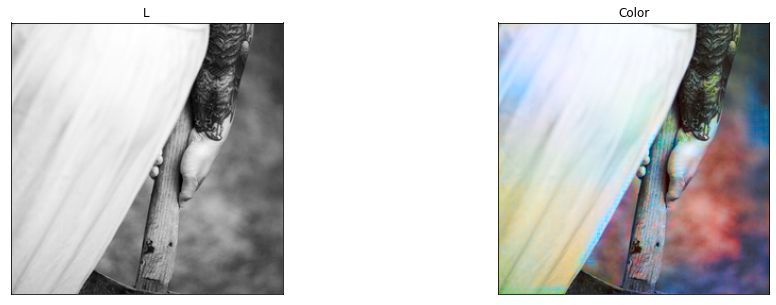

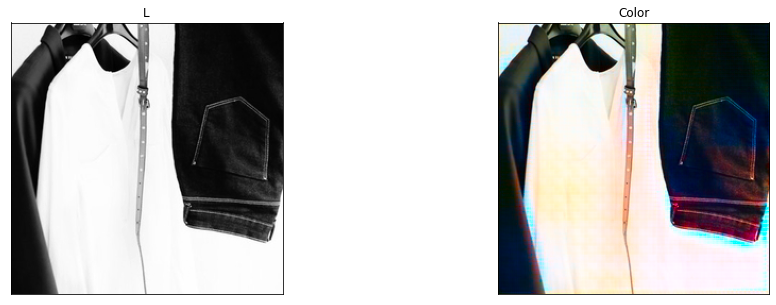

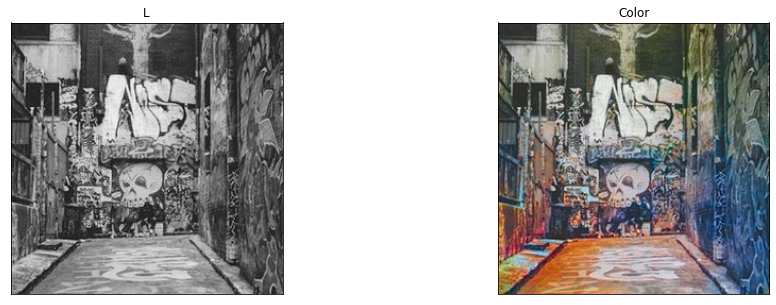

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


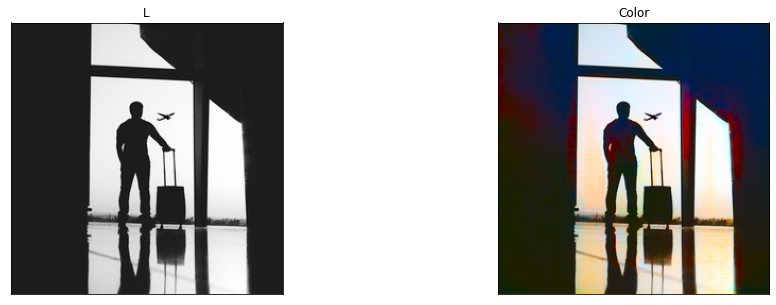

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 69 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


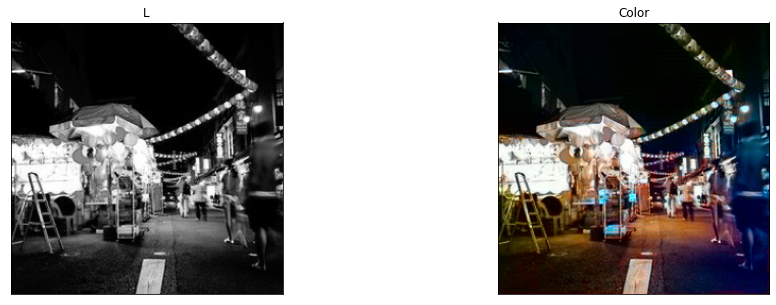

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


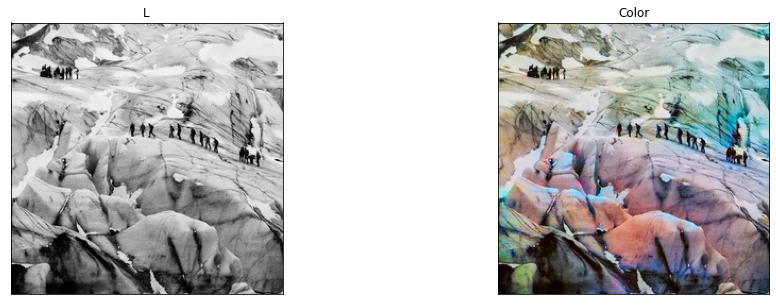

In [48]:
for image in np.random.choice(test_images, size=10):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lab_img = rgb2lab(img).astype(np.float32)
    lab_img = T.ToTensor()(lab_img)
    L = lab_img[[0], ...] / 50. - 1. # Between -1 and 1
    
    with torch.no_grad():
        pred_ab = unet(L.unsqueeze(0).to('cuda'))

    L_true = lab_img[[0], ...]
    pred_ab = pred_ab * 110.
    Lab_pred = torch.cat([L_true, pred_ab.squeeze(0).cpu()])

    Lab_pred = Lab_pred.permute(1, 2, 0).numpy()

    visualize(
        L=L_true.permute(1, 2, 0).numpy(), color=lab2rgb(Lab_pred)
    )